This section performs data collection and basic cleaning required for exploratory analysis.
No feature engineering or modeling decisions are made here.

In [ ]:
# loading libraries
import numpy as np
import pandas as pd
import requests
import time

# visualisation
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import plot_importance


# processing data
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# regression models
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor, GradientBoostingRegressor

# score
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, confusion_matrix
from sklearn.metrics import mean_squared_error, r2_score

# date transforming
from datetime import datetime
import datetime as dt

# xgboost
from xgboost import XGBClassifier, XGBRegressor

# tqdm
from tqdm import tqdm

In [ ]:
# api imformation
api_key = '#'
BASE_URL = "https://api.balldontlie.io/v1"
headers = {"Authorization": api_key}

In [ ]:
# this will write a function that we get all endpoints from this function so the error will be easy to see
def api_get(endpoint, params=None):
    url = f"{BASE_URL}/{endpoint}"
    r = requests.get(url, params=params, headers=headers)

    try:
        r.raise_for_status()
    except Exception as e:
        print("HTTP error:", r.status_code)
        print("Response:", r.text[:300])
        raise e

    try:
        return r.json()
    except:
        print("JSON decode error. Raw response:")
        print(r.text[:300])
        raise

In [ ]:
def get_stats_range(start_date, end_date, per_page=100, max_retry=5):

    print(f"Fetching stats {start_date} → {end_date}")

    all_rows = []
    cursor = None
    batch_id = 0

    while True:
        batch_id += 1

        params = {
            "start_date": start_date,
            "end_date": end_date,
            "per_page": per_page,
        }
        if cursor:
            params["cursor"] = cursor

        # retry block
        data = None
        for attempt in range(max_retry):
            try:
                data = api_get("stats", params)
                break
            except Exception:
                print(f"Retry {attempt+1}/{max_retry} at cursor={cursor}")
                time.sleep(1)

        if data is None:
            print("Failed too many times. Stopping.")
            break

        batch = data.get("data", [])
        if not batch:
            print("Empty batch. Done.")
            break

        all_rows.extend(batch)
        print(f"Batch {batch_id:03d}: +{len(batch)} rows (total={len(all_rows)})")

        cursor = data.get("meta", {}).get("next_cursor")
        if not cursor:
            print("No next cursor. Finished.")
            break

    df = pd.json_normalize(all_rows)

    if "game.date" in df.columns:
        df["game.date"] = pd.to_datetime(df["game.date"])

    return df

In [ ]:
def clean_stats(df):
    df = df.copy()

    # drop duplicate player-game rows
    df = df.drop_duplicates(subset=["player.id", "game.id"])

    # convert game.date
    df["game.date"] = pd.to_datetime(df["game.date"])

    # convert minutes ("35" or "35:22") into float
    def parse_min(x):
        if isinstance(x, str):
            if ":" in x:
                m, s = x.split(":")
                return float(m) + float(s)/60
            return float(x)
        return float(x)

    df["min"] = df["min"].apply(parse_min)

    # missing draft → fill with 0
    df["player.draft_year"] = df["player.draft_year"].fillna(0).astype(int)
    df["player.draft_round"] = df["player.draft_round"].fillna(0).astype(int)
    df["player.draft_number"] = df["player.draft_number"].fillna(0).astype(int)

    # drop useless OT3 columns if exist
    for col in ["game.home_ot3", "game.visitor_ot3", "game.datetime"]:
        if col in df.columns:
            df = df.drop(columns=[col], errors="ignore")

    return df

In [ ]:

START_DATE = "2025-10-01"
END_DATE = "2025-12-01"

df_raw = get_stats_range(
    start_date=START_DATE,
    end_date=END_DATE
)

print(df_raw.shape)
df_raw.head()

Fetching stats 2025-10-01 → 2025-12-01
Batch 001: +100 rows (total=100)
Batch 002: +100 rows (total=200)
Batch 003: +100 rows (total=300)
Batch 004: +100 rows (total=400)
Batch 005: +100 rows (total=500)
Batch 006: +100 rows (total=600)
Batch 007: +100 rows (total=700)
Batch 008: +100 rows (total=800)
Batch 009: +100 rows (total=900)
Batch 010: +100 rows (total=1000)
Batch 011: +100 rows (total=1100)
Batch 012: +100 rows (total=1200)
Batch 013: +100 rows (total=1300)
Batch 014: +100 rows (total=1400)
Batch 015: +100 rows (total=1500)
Batch 016: +100 rows (total=1600)
Batch 017: +100 rows (total=1700)
Batch 018: +100 rows (total=1800)
Batch 019: +100 rows (total=1900)
Batch 020: +100 rows (total=2000)
Batch 021: +100 rows (total=2100)
Batch 022: +100 rows (total=2200)
Batch 023: +100 rows (total=2300)
Batch 024: +100 rows (total=2400)
Batch 025: +100 rows (total=2500)
Batch 026: +100 rows (total=2600)
Batch 027: +100 rows (total=2700)
Batch 028: +100 rows (total=2800)
Batch 029: +100 ro

,id,min,fgm,fga,fg_pct,fg3m,fg3a,fg3_pct,ftm,fta,...,game.visitor_q2,game.visitor_q3,game.visitor_q4,game.visitor_ot1,game.visitor_ot2,game.visitor_ot3,game.visitor_timeouts_remaining,game.visitor_in_bonus,game.home_team_id,game.visitor_team_id
0,20748292,45,2,12,0.166667,0,8,0.000000,2,2,...,27,22,25,11.0,9.0,None,0,False,21,11
1,20748293,38,11,17,0.647059,2,5,0.400000,4,4,...,27,22,25,11.0,9.0,None,0,False,21,11
2,20748294,37,2,5,0.400000,0,1,0.000000,2,2,...,27,22,25,11.0,9.0,None,0,False,21,11
3,20748295,42,5,10,0.500000,3,8,0.375000,1,2,...,27,22,25,11.0,9.0,None,0,False,21,11
4,20748296,47,12,26,0.461539,1,9,0.111111,10,14,...,27,22,25,11.0,9.0,None,0,False,21,11


Analysing Data

In [ ]:
# cleaning before checking
df = clean_stats(df_raw)

print(df.shape)
df.head()

(10779, 67)


,id,min,fgm,fga,fg_pct,fg3m,fg3a,fg3_pct,ftm,fta,...,game.visitor_q1,game.visitor_q2,game.visitor_q3,game.visitor_q4,game.visitor_ot1,game.visitor_ot2,game.visitor_timeouts_remaining,game.visitor_in_bonus,game.home_team_id,game.visitor_team_id
0,20748292,45.0,2,12,0.166667,0,8,0.000000,2,2,...,30,27,22,25,11.0,9.0,0,False,21,11
1,20748293,38.0,11,17,0.647059,2,5,0.400000,4,4,...,30,27,22,25,11.0,9.0,0,False,21,11
2,20748294,37.0,2,5,0.400000,0,1,0.000000,2,2,...,30,27,22,25,11.0,9.0,0,False,21,11
3,20748295,42.0,5,10,0.500000,3,8,0.375000,1,2,...,30,27,22,25,11.0,9.0,0,False,21,11
4,20748296,47.0,12,26,0.461539,1,9,0.111111,10,14,...,30,27,22,25,11.0,9.0,0,False,21,11


In [ ]:
# checking if there is null data and Dtype
df.info()
df.describe().T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10779 entries, 0 to 10778
Data columns (total 67 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   id                               10779 non-null  int64         
 1   min                              10779 non-null  float64       
 2   fgm                              10779 non-null  int64         
 3   fga                              10779 non-null  int64         
 4   fg_pct                           10777 non-null  float64       
 5   fg3m                             10779 non-null  int64         
 6   fg3a                             10779 non-null  int64         
 7   fg3_pct                          10717 non-null  float64       
 8   ftm                              10779 non-null  int64         
 9   fta                              10779 non-null  int64         
 10  ft_pct                           10643 non-null  float64  

,count,mean,min,25%,50%,75%,max,std
id,10779.0,21559341.758419,20748292.0,21136549.5,21543497.0,21972572.5,22381007.0,483710.046007
min,10779.0,13.820206,0.0,0.0,12.0,26.0,52.0,13.566984
fgm,10779.0,2.39345,0.0,0.0,1.0,4.0,18.0,3.156615
fga,10779.0,5.099638,0.0,0.0,3.0,9.0,45.0,6.141123
fg_pct,10777.0,0.270262,0.0,0.0,0.25,0.5,1.0,0.290525
fg3m,10779.0,0.762594,0.0,0.0,0.0,1.0,10.0,1.30145
fg3a,10779.0,2.125336,0.0,0.0,1.0,4.0,17.0,2.90819
fg3_pct,10717.0,0.16869,0.0,0.0,0.0,0.333333,1.0,0.262725
ftm,10779.0,1.129789,0.0,0.0,0.0,2.0,23.0,2.192986
fta,10779.0,1.433528,0.0,0.0,0.0,2.0,26.0,2.631283


In [ ]:
# most variables contain no missing values, indicating high overall data completeness.
missing = df.isna().mean().sort_values(ascending=False)
missing[missing > 0]

,0
game.home_ot2,0.983672
game.visitor_ot2,0.983672
game.visitor_ot1,0.941182
game.home_ot1,0.941182
ft_pct,0.012617
player.weight,0.007793
fg3_pct,0.005752
player.jersey_number,0.000649
fg_pct,0.000186


In [ ]:
# overtime-related variables show very high missing rates, reflecting the rarity of overtime games
missing.loc[
    ["game.home_ot1", "game.home_ot2", "game.visitor_ot1", "game.visitor_ot2"]
]

,0
game.home_ot1,0.941182
game.home_ot2,0.983672
game.visitor_ot1,0.941182
game.visitor_ot2,0.983672


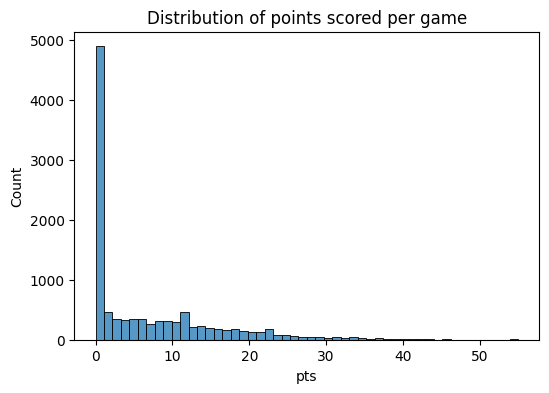

In [ ]:
# The median points scored is low and have a lot 0, while numerous high-value observations create a long right tail
plt.figure(figsize=(6,4))
sns.histplot(df["pts"], bins=50)
plt.title("Distribution of points scored per game")
plt.show()

In [ ]:
# The distribution of points scored per game exhibits a pronounced long tail, with the 90th, 95th, and 99th percentiles at 20, 25, and 35 points respectively
df["pts"].quantile([0.9, 0.95, 0.99])

,pts
0.90,20.0
0.95,25.0
0.99,35.0


Summary

This exploratory data analysis is based on 10,779 player–game observations from the 2025 NBA season, with a well-defined structure and diverse variable types.
Most variables exhibit no missing values, indicating high overall data completeness; overtime-related variables show high missing rates, reflecting the rarity of overtime games rather than data quality issues.
Points scored (pts) and minutes played (min) display strongly right-skewed distributions, with most observations concentrated at low values and a small number of high-usage performances forming a long tail.
Quantile analysis further confirms that high-scoring games constitute a small fraction of observations and represent genuine but rare events.
Overall, the dataset captures the inherent imbalance in player participation and performance in NBA games and provides a solid foundation for subsequent feature engineering and modeling.

## Save Raw Data

The cleaned dataset is saved as a raw data snapshot for reproducibility.
This file does not include any feature engineering or modeling-related transformations.


In [ ]:
import os
os.getcwd()

'/content'

In [ ]:
import os

os.makedirs("data", exist_ok=True)
df.to_csv("data/df_raw_v1.csv", index=False)

print("Saved to /content/data/df_raw_v1.csv")

Saved to /content/data/df_raw_v1.csv


In [ ]:
df.to_csv("data/raw_data.csv", index=False)